In qgan 4, let me try a slightly different circuit.

In qgan 4.1, adjust number of layers.

In 4.1.1, adjust the discriminator learning rate a little bit.

4.1.3 is based on 4.1.1 and tries to fix the random generation issue.
4.1.3 not based on 4.1.2

4.1.4 is when you combine what you have for 4.1.2 and 4.1.3

In [228]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

In [229]:
REAL_LABEL = 1
FAKE_LABEL = 0
OUT_DIM = 4
PER_SITE_QUBITS = 3
n_qubits = OUT_DIM * PER_SITE_QUBITS

is_local_simulator = True

g_repeats_1  = 1
g_repeats_2  = 4
g_batch_size = 16
d_batch_size = 16

d_repeats = 1

n_epoch = 200
epoch_1 = 100

d_pretrain_epoch = 5

n_layers = 3
final_rotation_layer = True

lr = 4e-4


spsa_alpha = 0.05
spsa_gamma = 0.01
spsa_c     = 0.05
spsa_A     = 2e4
spsa_a1    = 2e-4
spsa_a     = spsa_a1 * (spsa_A + 1) ** spsa_alpha

name = "qgan-4.1.4"

save_folder = f"saved/{name}"

data_path = "images_4s.npy"

seed = 2

max_data = 0.4

In [230]:
## some code to prevent the the output from being saved to the wrong directory

if globals().get("__file__") and os.path.basename(globals["__file__"]) != name + ".py":
    raise UserWarning("The 'name' variable does not match the file name.")
if globals().get("__vsc_ipynb_file__") and os.path.basename(globals().get("__vsc_ipynb_file__")) != name + ".ipynb":
    raise UserWarning("The 'name' variable does not match the file name.")

In [231]:
if os.path.exists(save_folder):
    print(f"This notebook may overwrite previous results in the {save_folder} directory")
else:
    os.makedirs(save_folder)

rng = np.random.default_rng(seed)

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)


This notebook may overwrite previous results in the saved/qgan-4.1.4 directory


In [232]:
data_true = np.load(data_path)
data_true = np.clip(data_true, 0, max_data)
rng.shuffle(data_true)
data_true = torch.tensor(data_true, dtype = torch.float32, device=device, requires_grad=False)
data_loader = torch.utils.data.DataLoader(data_true, batch_size=d_batch_size, shuffle = True)

In [233]:
if n_qubits %2 != 0:
    raise ValueError("Odd number of qubits not supported right now.")

n_1q_parameters = 2 * n_qubits * (2 * n_layers + 1) if final_rotation_layer else  2 * n_qubits * (2 * n_layers + 0)
n_2q_parameters = n_qubits * n_layers

n_parameters = n_1q_parameters + n_2q_parameters

print(f"There are {n_1q_parameters} parameters controlling 1-qubit rotations.")
print(f"There are {n_2q_parameters} parameters controlling 2-qubit rotations.")
print(f"Therer are {n_1q_parameters + n_2q_parameters} trainable parameters in the circuit.")

There are 168 parameters controlling 1-qubit rotations.
There are 36 parameters controlling 2-qubit rotations.
Therer are 204 trainable parameters in the circuit.


In [234]:
# par_1q_rots = ParameterVector(r"$\theta$", n_1q_parameters)
# par_2q_rots = ParameterVector(r"$\Theta$", n_2q_parameters)
par_weights = ParameterVector(r"$\theta$", n_parameters)

In [235]:
qc = QuantumCircuit(n_qubits)

for layer in range(n_layers):
    for i in range(n_qubits):
        qc.rx(par_weights[4 * n_qubits * layer + 2*i + 0], i)
        qc.rz(par_weights[4 * n_qubits * layer + 2*i + 1], i)
    for i in range(0, n_qubits, 2):
        qc.rxx(par_weights[n_1q_parameters + n_qubits * layer + i], i, (i+1)%n_qubits)
    for i in range(n_qubits):
        qc.rx(par_weights[2*n_qubits*(2*layer+1) + 2*i + 0], i)
        qc.rz(par_weights[2*n_qubits*(2*layer+1) + 2*i + 1], i)
    for i in range(1, n_qubits, 2):
        qc.rxx(par_weights[n_1q_parameters + n_qubits * layer + i], i, (i+1)%n_qubits)

if final_rotation_layer:
    for i in range(n_qubits):
        qc.rx(par_weights[4*n_qubits*n_layers + 2*i + 0], i)
        qc.rz(par_weights[4*n_qubits*n_layers + 2*i + 1], i)



qc.measure_all()


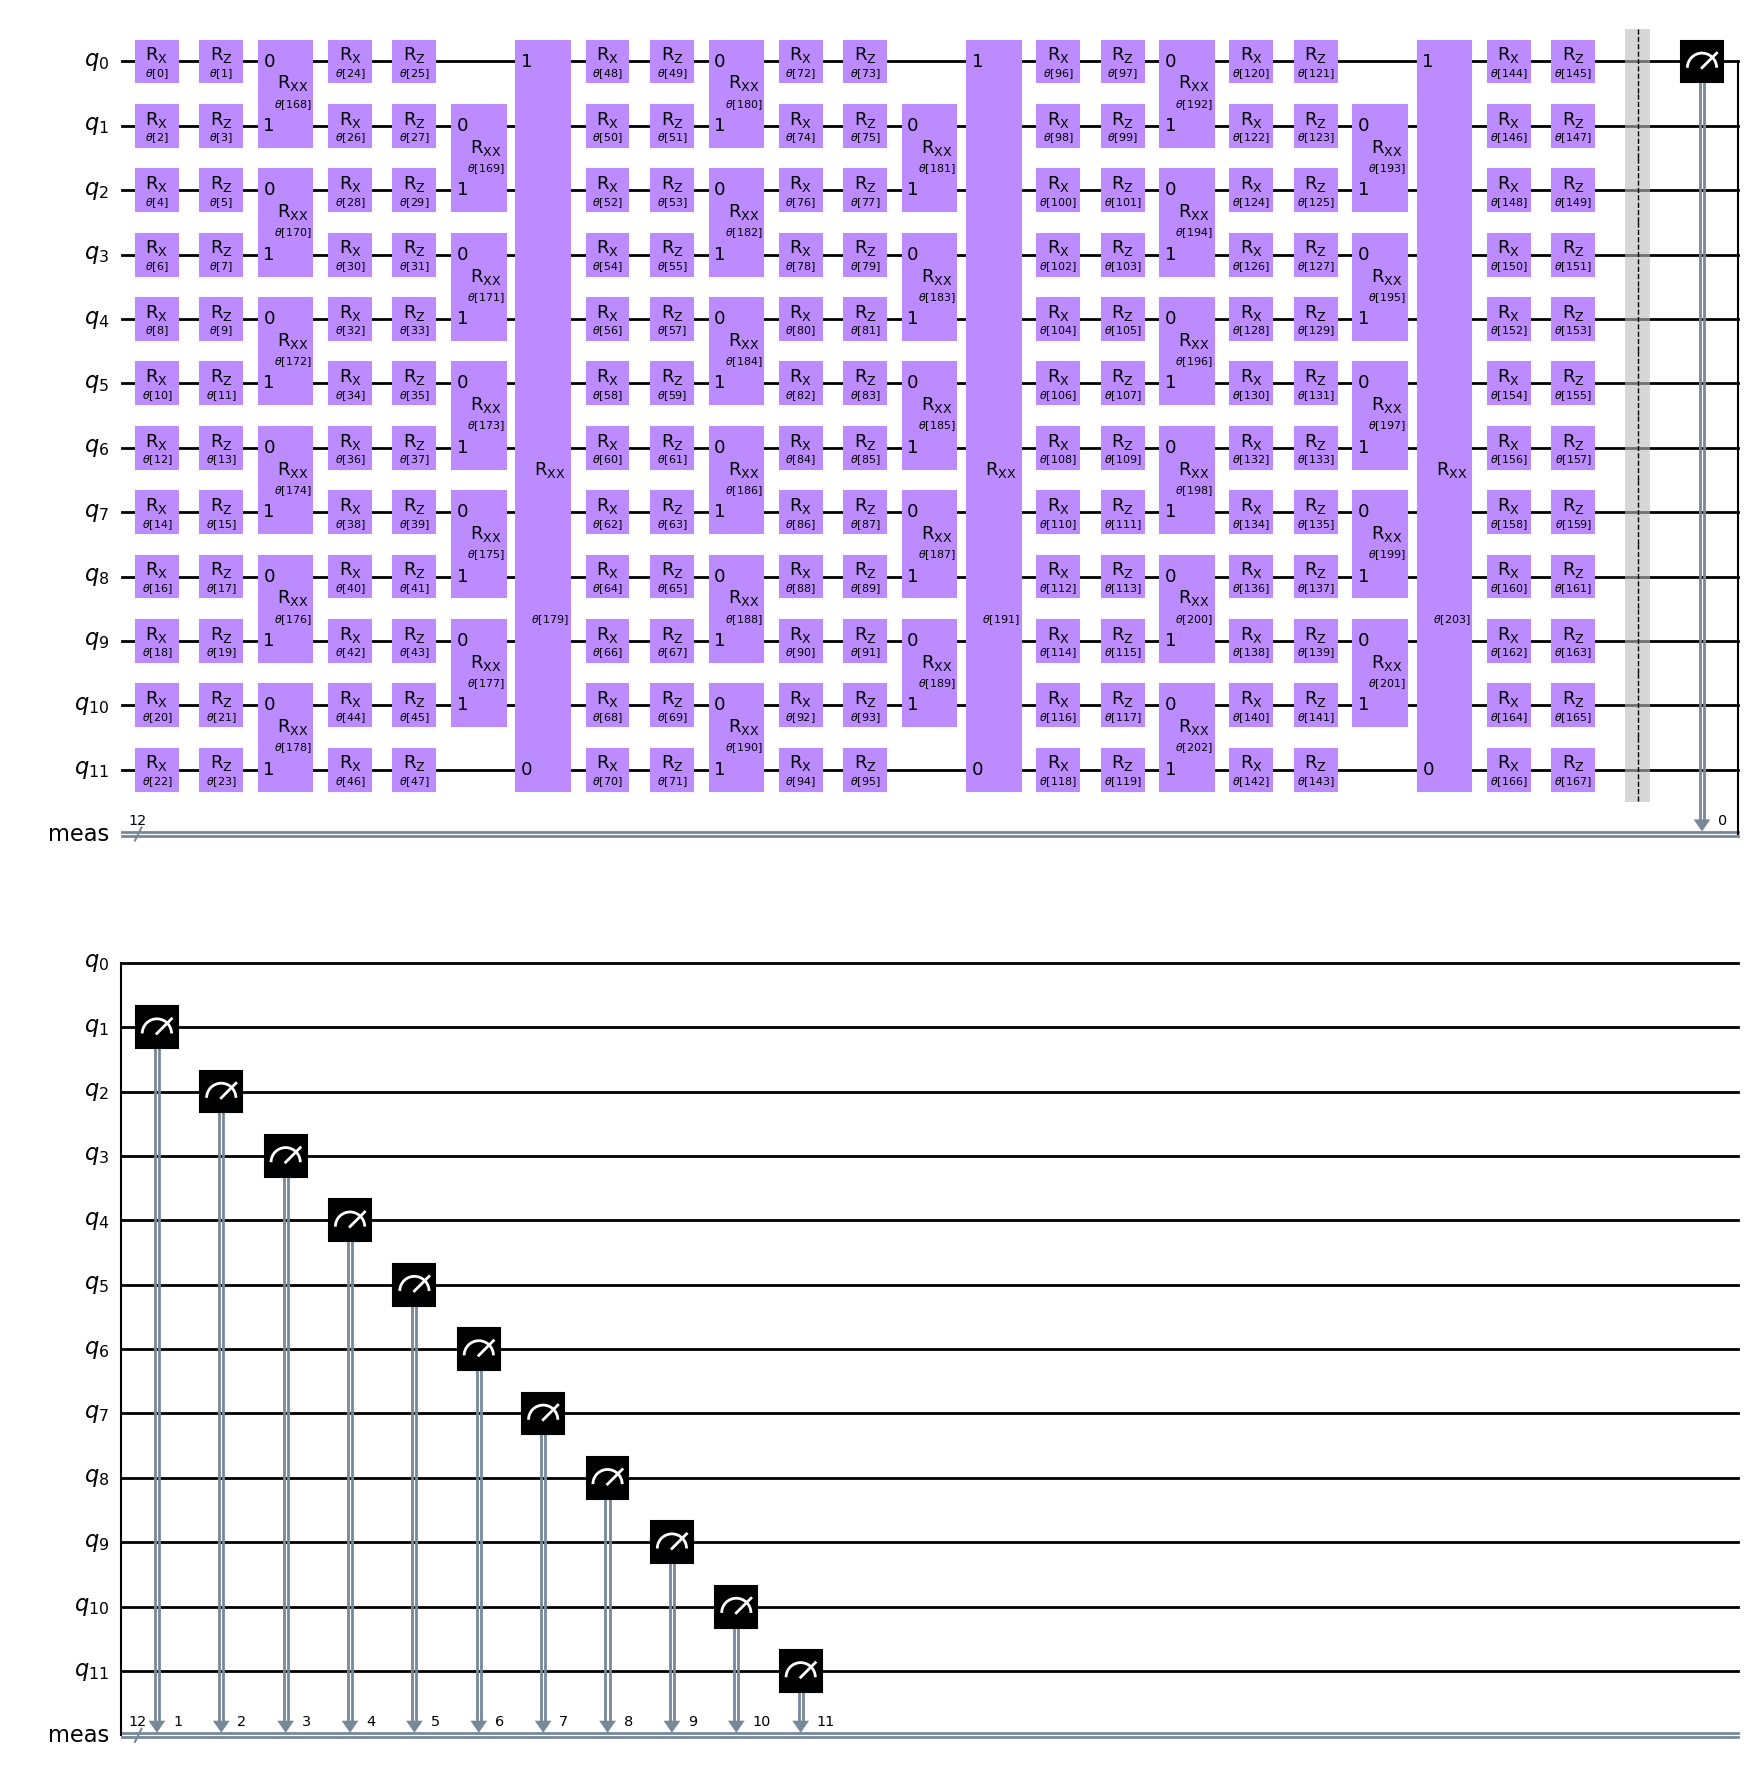

In [236]:
qc.draw(output="mpl", style="clifford")


In [237]:
# simulator = AerSimulator(device="GPU")
simulator = AerSimulator()
rng = np.random.default_rng()

In [238]:
def string_to_array(string):
    ls = []
    for c in string:
        ls.append(int(c))
    return ls

def key_convert(key, qubits_per_site=3):
    new_key = ""
    for i in range(0, len(key), qubits_per_site):
        val = int(key[i:i+qubits_per_site], 2)  # 3-bit binary → int [0–7]
        new_key += str(val)
    return new_key

def dict_to_ndarray(dict_data):
    data_array = []

    for result, count in dict_data.items():
        result = string_to_array(result)
        for i in range(count):
            data_array.append(result)
    return np.array(data_array)

def generate(parameters, shots):
    circuit = qc.assign_parameters({par_weights:parameters})
    job = simulator.run(circuit, shots=shots)
    result = job.result()
    counts_dict = result.get_counts()
    result_dict = {key_convert(key, 3): val for key, val in counts_dict.items()}
    result_arr  = dict_to_ndarray(result_dict)
    result_arr_rescaled = result_arr * 1/4 + 1/8
    result_arr_spread   = result_arr_rescaled + rng.uniform(-1/8, 1/8, size = result_arr_rescaled.shape)
    return result_arr_spread * max_data


In [239]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 2.0)
        m.bias.data.uniform_(-1.0, 1.0)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Linear(OUT_DIM, 32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 16),
#             nn.LeakyReLU(0.2),
#             nn.Linear(16, 8),
#             nn.LeakyReLU(0.2),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, input):
#         return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 12),
            nn.LeakyReLU(0.2),
            # nn.Linear(16, 8),
            # nn.LeakyReLU(0.2),
            nn.Linear(12, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [240]:
# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# # Initialize BCELoss function
criterion = nn.BCELoss()

# def criterion(output, label):
#     return torch.mean(torch.square(output - label))

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [241]:
# qc0 = qc.assign_parameters({par_weights:params})
# job = simulator.run(qc0, shots=16)
# count_dict = job.result().get_counts()

In [242]:
# count_dict

In [243]:
# generate(params, 10)

In [244]:
def updateD(real_batch, fake_batch):
    netD.zero_grad()
    real_batch = real_batch.to(device)
    b_size = real_batch.shape[0]
    label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
    output = netD(real_batch).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    fake_batch = torch.tensor(fake_batch, device=device, dtype=torch.float)
    label.fill_(FAKE_LABEL)
    output = netD(fake_batch.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_g = output.mean().item()
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()
    return errD.item(), D_x, D_g


In [245]:
class GOptimizer:
    def __init__(self, alpha=spsa_alpha, gamma=spsa_gamma, c=spsa_c, A=spsa_A, a=spsa_a, netD=netD, gen=generate, loss_func = criterion, rng=rng):
        self.k = 0
        self.alpha = alpha
        self.gamma = gamma
        self.c     = c
        self.A     = A
        self.a     = a
        self.netD  = netD
        self.gen   = gen
        self.loss_func = loss_func
        self.rng = rng

    def calculate_loss(self, parameters, shots):
        fake_batch = self.gen(parameters, shots)
        fake_batch = torch.tensor(fake_batch, device=device, dtype=torch.float)
        with torch.no_grad():
            output = self.netD(fake_batch).view(-1)
        label = torch.full((shots,), REAL_LABEL, dtype=torch.float, device=device)
        return self.loss_func(output, label).item()

    def stochastic_gradient(self, parameters, shots):
        self.k += 1

        ck = self.c / self.k**self.gamma
        param_deltas = rng.choice([-1., 1.], size = parameters.shape) * ck
        params_plus = parameters + param_deltas
        params_minus = parameters - param_deltas

        loss_plus = self.calculate_loss(params_plus, shots)
        loss_minus = self.calculate_loss(params_minus, shots)

        return (loss_plus - loss_minus) / 2 / param_deltas

    def next_params(self, parameters, shots):
        grad = self.stochastic_gradient(parameters, shots)

        ak = self.a / (self.A + self.k) ** self.alpha
        return parameters - ak * grad




In [246]:
# # pretraining for discriminator
# for epoch in range(1):
#     for i, data in enumerate(data_loader):


#         # optimize the discriminator
#         data = data.to(device)
#         fake = generate(rng.standard_normal(n_parameters), shots=d_batch_size)
#         updateD(data, fake)

In [247]:
g_optimizer = GOptimizer()
params_init = rng.standard_normal(n_parameters)
params = params_init

In [248]:
print(params)

[-3.14096167e-01  2.74888344e-01 -5.13058224e-01 -4.15622125e-01
 -6.12567307e-01  1.66868786e+00 -5.28492930e-01  1.39109992e-01
 -1.06278211e+00 -8.47418751e-01 -3.88649004e-01  6.12977601e-01
 -5.23035472e-01  8.63041371e-01 -8.94101797e-02 -5.22308086e-01
 -9.69006283e-01  3.41854059e-01  2.27540308e+00 -2.04756734e+00
 -4.54014053e-01  7.49136007e-01  1.66469640e+00  5.02792055e-01
  1.07540054e+00 -4.05025979e-01 -1.16868548e+00 -2.39103577e-01
 -1.27326238e-01  8.96392007e-01 -9.10525403e-01  3.07175585e-01
  9.08798275e-01 -1.18340595e+00  1.88238092e-01  4.29400702e-01
  2.14625053e+00  1.57454790e+00  6.21084094e-01  8.73261353e-01
  4.01042027e-01  5.66873222e-02 -1.07288581e+00 -1.19187957e+00
  5.09528351e-01 -2.81751535e+00  5.20865718e-01  1.98422198e-01
  1.34165806e+00 -1.60958945e+00  3.05815752e-01  1.82127498e-01
 -2.40231421e-01 -2.91742588e-01  8.47711765e-01  1.10742542e+00
  1.78622625e+00 -1.53818843e+00 -3.50204448e-01 -6.78985784e-01
  1.27271678e+00 -2.59202

In [249]:
for epoch in range(d_pretrain_epoch):
    for i, data in enumerate(data_loader):
        # optimize the discriminator
        data = data.to(device)
        fake = generate(params, shots=data.shape[0])
        print(fake.shape)
        loss_D, D_x, D_g = updateD(data, fake)

(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(9, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(16, 4)
(

In [ ]:


G_losses = []
D_losses = []

start = time.time()
now = start

print("Starting Training Loop...")

for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):


        
        # optimize the discriminator
        data = data.to(device)
        fake = generate(params, shots=data.shape[0])
        for j in range(d_repeats):
            loss_D, D_x, D_g = updateD(data, fake)

        # this part is not important
        with torch.no_grad():
            output = netD(torch.tensor(fake, device=device, dtype=torch.float)).view(-1)
            labels = torch.full((fake.shape[0],), REAL_LABEL, dtype=torch.float, device=device)
            loss_G = criterion(output, labels)


        if epoch < epoch_1:
            g_repeats = g_repeats_1
        else:
            g_repeats = g_repeats_2
        # optimize the generator
        for j in range(g_repeats):
            params = g_optimizer.next_params(params, g_batch_size)


        # print output
        if i%10 == 0:
            G_losses.append(loss_G)
            D_losses.append(loss_D)

            last, now = now, time.time()
            print(f"[{epoch+1}/{n_epoch}][{i}/{len(data_loader)}]\tLossD: {loss_D:.4f}\tLossG: {loss_G:.4f}\t" +
                f"D(x): {D_x:.4f}\tD(G(x)): {D_g:.4f}\tTime: {now-last:.1f}s")
        


Starting Training Loop...
[1/200][0/64]	LossD: 1.0526	LossG: 3.8288	D(x): 0.8211	D(G(x)): 0.2241	Time: 0.0s
[1/200][10/64]	LossD: 14.3577	LossG: 3.3955	D(x): 0.8156	D(G(x)): 0.3414	Time: 0.4s
[1/200][20/64]	LossD: 2.6795	LossG: 2.7958	D(x): 0.7597	D(G(x)): 0.4474	Time: 0.4s
[1/200][30/64]	LossD: 2.1805	LossG: 3.3961	D(x): 0.8705	D(G(x)): 0.3394	Time: 0.4s
[1/200][40/64]	LossD: 3.2779	LossG: 2.6413	D(x): 0.8850	D(G(x)): 0.4962	Time: 0.4s
[1/200][50/64]	LossD: 2.5888	LossG: 2.8782	D(x): 0.8012	D(G(x)): 0.4772	Time: 0.4s
[1/200][60/64]	LossD: 0.6910	LossG: 3.6643	D(x): 0.7986	D(G(x)): 0.2359	Time: 0.4s
[2/200][0/64]	LossD: 1.5465	LossG: 3.5893	D(x): 0.8717	D(G(x)): 0.3453	Time: 0.2s
[2/200][10/64]	LossD: 2.1188	LossG: 2.2964	D(x): 0.9067	D(G(x)): 0.3620	Time: 0.4s
[2/200][20/64]	LossD: 2.4802	LossG: 2.4710	D(x): 0.8180	D(G(x)): 0.4871	Time: 0.4s
[2/200][30/64]	LossD: 2.2943	LossG: 2.4577	D(x): 0.8170	D(G(x)): 0.3537	Time: 0.4s
[2/200][40/64]	LossD: 1.8067	LossG: 4.6125	D(x): 0.8208	D(G(x)

In [ ]:
finish = time.time()
print(f"Training takes {round(finish-start)}s.")

Training takes 243s.


In [ ]:
print(params)

[ 1.30359291e+00 -6.62202156e-01 -4.35872190e-01  3.28562927e-01
 -2.36105649e-01 -1.00429400e+00 -2.59329651e-01 -2.91258641e-01
 -1.07796805e+00 -7.47024232e-01 -1.13976767e+00 -1.31963150e+00
 -3.16047324e+00 -7.07992160e-01 -1.27338911e+00 -5.47861334e-01
  2.06539617e+00  1.29725463e+00 -1.34107183e+00  1.43921452e+00
  3.95658184e-01 -1.91609716e+00  1.57675714e+00 -8.32284258e-01
 -2.20166712e-01 -3.22490990e-01  1.91535280e-01 -2.03094293e+00
  9.22828239e-01  2.61387936e-01  2.00927488e+00  3.93570501e-01
  1.16306561e+00  1.39633823e+00  1.06361904e+00  8.51323336e-01
 -1.17130081e+00  2.44612542e-01 -3.09019204e-01 -1.19526286e-01
  1.24914774e-01  2.58336411e-01 -2.01620343e-01 -6.00964965e-02
 -9.43088521e-01  8.89679907e-01  7.25862190e-01 -4.20071898e-01
  1.58113213e-01  1.58277627e+00 -1.59050666e+00 -3.51536926e+00
 -1.81740552e+00 -3.47511695e-01 -1.07587409e+00  2.55012315e-01
  2.11609661e+00 -7.91286229e-01  2.14155793e+00  7.51533955e-01
 -5.86921805e-01  3.85319

In [ ]:
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

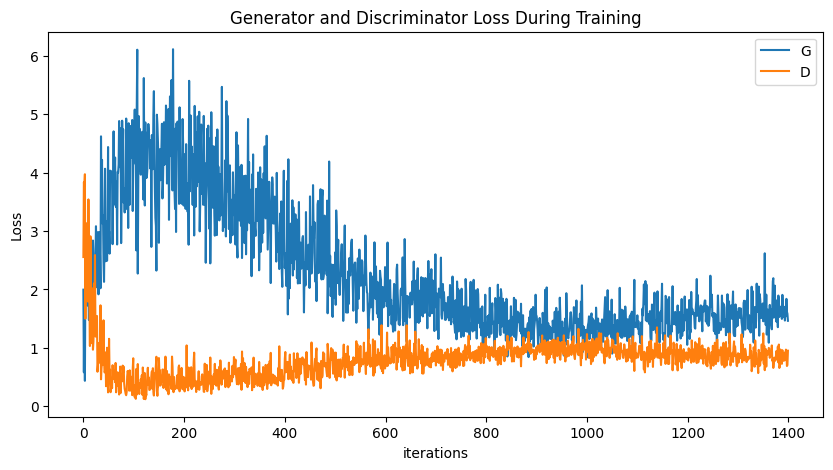

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(os.path.join(save_folder, "loss.png"))

In [ ]:
n_rows = 2
n_cols = 4

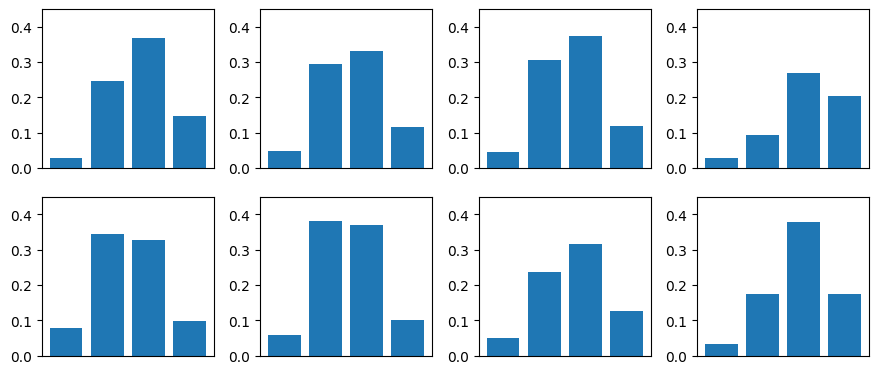

In [ ]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4))

for i, ax in enumerate(axes.flatten()):
    # ax.axis("off")
    # ax.plot(real_batch[i].cpu())
    fig.tight_layout()
    ax.set(ylim=[0, max_data + 0.05])
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks([])
    # ax.xlabel("off")
    ax.bar(range(4), real_batch[i].cpu())
    # ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")
fig.savefig(os.path.join(save_folder, "real_images.png"))


In [ ]:
# real_batch = next(iter(data_loader))

# fig, axes = plt.subplots(n_rows, n_cols)

# for i, ax in enumerate(axes.flatten()):
#     ax.axis("off")
#     ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")

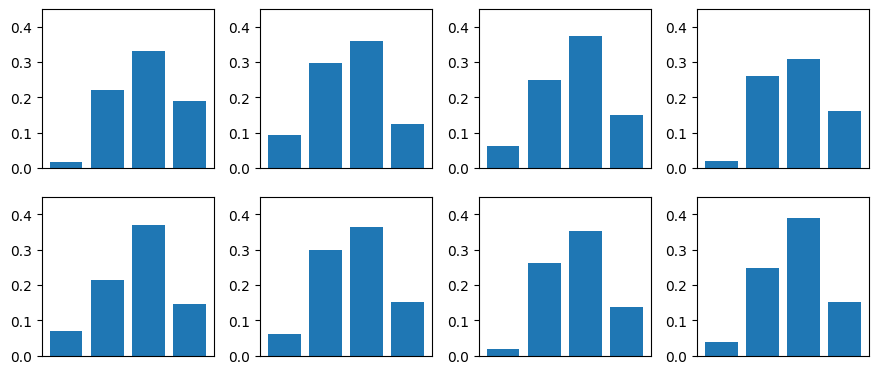

In [ ]:
b_size = n_rows * n_cols

fake_batch = generate(params, b_size)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4))
for i, ax in enumerate(axes.flatten()):
    # ax.axis("off")
    fig.tight_layout()
    ax.set(ylim=[0, max_data + 0.05])
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks([])
    ax.bar(range(4), fake_batch[i])
fig.savefig(os.path.join(save_folder, "fake_images.png"))


In [ ]:
# b_size = n_rows * n_cols

# fake_batch = generate(params, b_size)

# fig, axes = plt.subplots(n_rows, n_cols)
# for i, ax in enumerate(axes.flatten()):
#     ax.axis("off")
#     ax.imshow(fake_batch[i].reshape(2, 2), cmap="binary")

In [ ]:
sample_size = 900
data_index = torch.randperm(data_true.shape[0])[:sample_size]
real_samples = data_true[data_index]

fake_samples = generate(params, sample_size)

np.savez(save_folder + "/samples.npz", 
    real_samples = real_samples.cpu(), 
    fake_samples = fake_samples
)

In [ ]:
with torch.no_grad():
    real_scores = netD(real_samples).cpu()
    fake_scores = netD(torch.tensor(fake_samples, device=device, dtype=torch.float)).cpu()

In [ ]:
print(np.mean(real_scores.numpy()))
print(np.mean(fake_scores.numpy()))


0.70328426
0.30129167


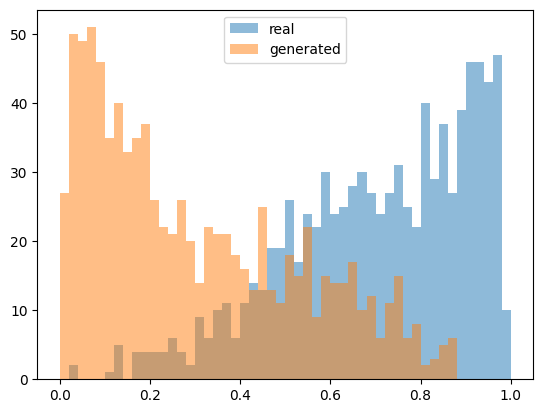

In [ ]:
fig, ax = plt.subplots()



ax.hist(real_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="real")
ax.hist(fake_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")

ax.legend()

fig.savefig(os.path.join(save_folder, "hist.png"))


In [ ]:
for p in netD.parameters():
    print(p)

Parameter containing:
tensor([[-4.2682,  0.0915,  3.7163,  4.5938],
        [-2.9813,  2.2372, -1.0667,  1.6517],
        [ 1.2082,  0.6091,  0.9840,  4.7187],
        [-0.5574, -0.9521, -2.1962,  0.6655],
        [ 2.9368,  0.7458,  0.0739,  1.6489],
        [-3.1707,  1.6001, -1.8517,  1.6990],
        [ 2.8975,  2.2352,  0.1803, -2.2137],
        [ 1.4512,  0.5902,  0.1879,  0.6021],
        [ 1.1718, -2.0668, -1.4333,  1.2899],
        [ 0.5556, -1.7455,  2.0406, -0.0451],
        [ 2.2681,  4.3140, -2.2812, -0.6408],
        [-2.4563, -2.8149,  1.4081, -0.4161]], requires_grad=True)
Parameter containing:
tensor([ 0.1651, -0.3063, -1.0839,  0.0080, -0.2568,  0.6208,  1.1034, -0.9873,
        -0.1588, -0.5926, -0.3154, -0.5522], requires_grad=True)
Parameter containing:
tensor([[ 0.0976,  3.2312, -0.3775, -1.6477, -0.7455, -0.3293,  1.9382, -2.5422,
          3.8564,  1.9966, -2.2766, -1.2038],
        [ 1.1150, -1.4944, -0.9431, -0.3026, -0.1974, -5.2463, -3.5611, -1.3795,
        

In [ ]:
# json_path = data_path[:-4] + ".json"
# with open(json_path, 'r') as f:
#     real_data_dict = json.load(f)

# def np_to_dict(result_np):
#     result_dict = {}
#     for line in result_np:
#         str_key = ""
#         for i in line:  # reversing the order to match qiskit notation
#             str_key+=(str(i))
#         current_value = result_dict.get(str_key, 0)
#         result_dict[str_key] = current_value + 1
#     return result_dict

# fake_data = generate(params, 20480)

# fake_data_dict = np_to_dict(fake_data)

# all_keys = (set(real_data_dict.keys())) | (set(fake_data_dict.keys()))

# real_counts = []
# fake_counts = []

# for k in all_keys:
#     real_counts.append(real_data_dict.get(k, 0))
#     fake_counts.append(fake_data_dict.get(k, 0))

# real_counts = np.array(real_counts)
# fake_counts = np.array(fake_counts)

# real_probs = real_counts / np.sum(real_counts)
# fake_probs = fake_counts / np.sum(fake_counts)

# mixed_probs = (real_probs + fake_probs) / 2 # here, every entry of mixed_probs are positive

# # Note, mixed_probs is all positive. That's why you can use nan_to_num to deal with zero entries in real_probs or fake_probs
# dl_r = np.sum(real_probs * np.nan_to_num(np.log(real_probs / mixed_probs)))
# dl_f = np.sum(fake_probs * np.nan_to_num(np.log(fake_probs / mixed_probs)))

# jl_div = (dl_r + dl_f) / 2

# print(f"JL-divergens is {jl_div}")


In [ ]:
# train a standalone discriminator to evaluate the performance of the GAN "objectively"
class Evaluator(nn.Module):
    def __init__(self):
        super(Evaluator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 16),
            # nn.LeakyReLU(0.2),
            # nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [ ]:
netEv = Evaluator().to(device)
netEv.apply(weights_init)

optimizer_ev = optim.Adam(netEv.parameters(), lr=lr, betas=(0.5, 0.999))
loss_ev = nn.BCELoss()
print(netEv)

Evaluator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
batch_size_ev = 16

In [ ]:
real_samples_np = real_samples.cpu().numpy()
fake_samples_np = fake_samples

samples = np.concatenate((real_samples_np, fake_samples_np))

real_labels = np.repeat(REAL_LABEL, real_samples_np.shape[0])
fake_labels = np.repeat(FAKE_LABEL, fake_samples_np.shape[0])
labels = np.concatenate((real_labels, fake_labels))

X_train, X_rest, y_train, y_rest = train_test_split(
    samples, labels, train_size = 0.6, shuffle = True, stratify = labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rest, y_rest, test_size = 0.5, shuffle = True, stratify = y_rest
)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
y_valid = torch.tensor(y_valid, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)


data_loader_ev = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size = batch_size_ev, shuffle = True)


In [ ]:
valid_losses = []
train_losses = []
iters = 0

netEv.train()
 

print("Starting the training loop")
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader_ev):
        netEv.zero_grad()
        X_batch = data[0].to(device)
        y_batch = data[1].to(device)
        prediction_batch = netEv(X_batch).view(-1)
        err = loss_ev(prediction_batch, y_batch)
        err.backward()
        optimizer_ev.step()

        if i%50 == 0:
            netEv.eval()
            with torch.no_grad():
                prediction_valid = netEv(X_valid).view(-1)
                prediction_train = netEv(X_train).view(-1)
            train_loss = loss_ev(prediction_train, y_train).item()
            valid_loss = loss_ev(prediction_valid, y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_acc  = torch.isclose(torch.round(prediction_valid), y_valid).sum().item()/len(y_valid)
            netEv.train()

            print(
                f"[{epoch+1}/{n_epoch}][{i}/{len(data_loader)}]\tLoss train: {train_loss:.3f}\tLoss valid: {valid_loss:.3f}\tLoss acc: {valid_acc:.3f}"
            )

Starting the training loop
[1/200][0/64]	Loss train: 49.280	Loss valid: 50.000	Loss acc: 0.500
[1/200][50/64]	Loss train: 49.270	Loss valid: 50.000	Loss acc: 0.500
[2/200][0/64]	Loss train: 49.266	Loss valid: 50.000	Loss acc: 0.500
[2/200][50/64]	Loss train: 49.256	Loss valid: 50.000	Loss acc: 0.500
[3/200][0/64]	Loss train: 49.018	Loss valid: 50.000	Loss acc: 0.500
[3/200][50/64]	Loss train: 48.218	Loss valid: 49.531	Loss acc: 0.500
[4/200][0/64]	Loss train: 47.491	Loss valid: 49.292	Loss acc: 0.500
[4/200][50/64]	Loss train: 4.381	Loss valid: 4.363	Loss acc: 0.497
[5/200][0/64]	Loss train: 2.330	Loss valid: 2.351	Loss acc: 0.483
[5/200][50/64]	Loss train: 0.691	Loss valid: 0.746	Loss acc: 0.714
[6/200][0/64]	Loss train: 0.689	Loss valid: 0.745	Loss acc: 0.714
[6/200][50/64]	Loss train: 0.684	Loss valid: 0.744	Loss acc: 0.711
[7/200][0/64]	Loss train: 0.685	Loss valid: 0.743	Loss acc: 0.711
[7/200][50/64]	Loss train: 0.682	Loss valid: 0.742	Loss acc: 0.706
[8/200][0/64]	Loss train: 0.

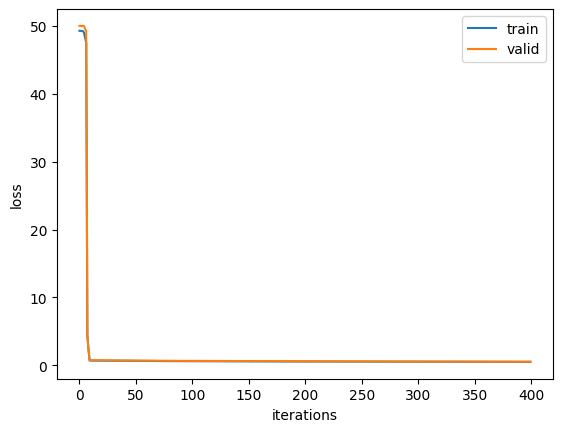

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

In [ ]:
netEv.eval()

with torch.no_grad():
    prediction_test = netEv(X_test).view(-1)

test_acc = torch.isclose(torch.round(prediction_test), y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.7055555555555556


In [ ]:
print(f"AUC score is {roc_auc_score(y_test, prediction_test)}")

AUC score is 0.7589197530864198


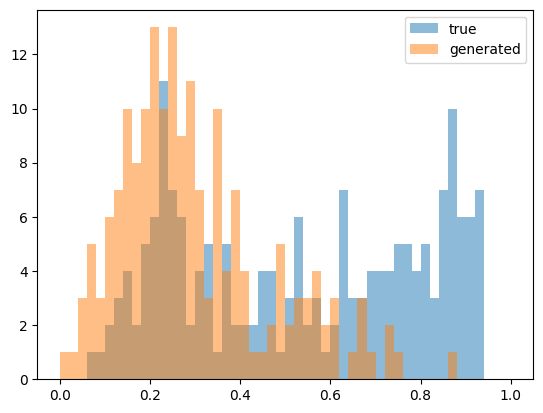

In [ ]:
true_indices = y_test.isclose(torch.tensor(1.0))
fake_indices = y_test.isclose(torch.tensor(0.0))

pred_true = prediction_test[true_indices]
pred_fake = prediction_test[fake_indices]

fig, ax = plt.subplots()
ax.hist(pred_true.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="true")
ax.hist(pred_fake.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")
ax.legend()

None